In [2]:
# step1_split.py
import os, csv
from pathlib import Path
from sklearn.model_selection import train_test_split

# ---------------- CONFIG ----------------
# From Notebooks/, go up one level -> AI_ML_Project -> Data/Raw/Tea Leaf Disease Dataset
DATASET_DIR = Path("../Data/Raw/Tea Leaf Disease Dataset")
OUT_DIR     = Path("../Data/Splits")

TEST_SIZE     = 0.20
VAL_SIZE      = 0.10
RANDOM_STATE  = 42
# -----------------------------------------

def list_images_with_labels(root_dir: Path):
    """Return (paths, labels) with paths relative to dataset root."""
    paths, labels = [], []
    classes = [d for d in root_dir.iterdir() if d.is_dir() and not d.name.startswith("_")]
    if not classes:
        raise ValueError(f"No class folders found under: {root_dir}")
    for cls in sorted(classes):
        for f in os.listdir(cls):
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".webp")):
                rel_path = cls / f   # keep path relative
                paths.append(str(rel_path))
                labels.append(cls.name)
    return paths, labels

def write_index_csv(index_tuples, out_csv: Path):
    """Write CSV file with [path,label]."""
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    with out_csv.open("w", newline="") as f:
        w = csv.writer(f); w.writerow(["path","label"])
        for p, y in index_tuples:
            w.writerow([p, y])

def stratified_split_index(
    data_dir: Path, out_dir: Path,
    test_size=0.20, val_size=0.10, random_state=42
):
    X, y = list_images_with_labels(data_dir)

    if not X:
        raise ValueError(f"No images found under: {data_dir}")

    if not (0 < test_size < 1 and 0 < val_size < 1 and test_size + val_size < 1):
        raise ValueError("test_size and val_size must be in (0,1) and sum to < 1.")

    # First split into Train vs (Val+Test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size+val_size, stratify=y, random_state=random_state
    )
    # Then split Val vs Test
    rel_val = val_size / (test_size+val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=1-rel_val, stratify=y_temp, random_state=random_state
    )

    write_index_csv(list(zip(X_train,y_train)), out_dir/"train_index.csv")
    write_index_csv(list(zip(X_val,  y_val)),  out_dir/"val_index.csv")
    write_index_csv(list(zip(X_test, y_test)), out_dir/"test_index.csv")

    print(f"Dataset split completed!")
    print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
    print(f"CSV files saved to: {out_dir.resolve()}")

    # Small preview
    for split_name, fname in [("Train", "train_index.csv"), ("Val", "val_index.csv"), ("Test", "test_index.csv")]:
        fpath = out_dir / fname
        with fpath.open() as f:
            lines = f.readlines()
        print(f"\n{split_name} CSV ({fname}): first 5 rows")
        print("".join(lines[:6]))   # header + 5 rows

# ---------------- RUN ----------------
if __name__ == "__main__" or True:   # also works inside Jupyter
    print("Using dataset at:", DATASET_DIR.resolve())
    stratified_split_index(
        data_dir=DATASET_DIR,
        out_dir=OUT_DIR,
        test_size=TEST_SIZE,
        val_size=VAL_SIZE,
        random_state=RANDOM_STATE,
    )

Using dataset at: /Users/tharukakumarasiri/Desktop/AI_ML_Project/Data/Raw/Tea Leaf Disease Dataset
Dataset split completed!
Train: 22694 | Val: 3242 | Test: 6485
CSV files saved to: /Users/tharukakumarasiri/Desktop/AI_ML_Project/Data/Splits

Train CSV (train_index.csv): first 5 rows
path,label
../Data/Raw/Tea Leaf Disease Dataset/brown_blight/brown_blight_0_2333.jpg,brown_blight
../Data/Raw/Tea Leaf Disease Dataset/gray_blight/gray_blight_0_6094.jpg,gray_blight
../Data/Raw/Tea Leaf Disease Dataset/red_spot/red_spot_0_5405.jpg,red_spot
../Data/Raw/Tea Leaf Disease Dataset/brown_blight/brown_blight_0_7020.jpg,brown_blight
../Data/Raw/Tea Leaf Disease Dataset/healthy/healthy_0_8371.jpg,healthy


Val CSV (val_index.csv): first 5 rows
path,label
../Data/Raw/Tea Leaf Disease Dataset/gray_blight/gray_blight_0_2987.jpg,gray_blight
../Data/Raw/Tea Leaf Disease Dataset/brown_blight/brown_blight_0_574.jpg,brown_blight
../Data/Raw/Tea Leaf Disease Dataset/algal_spot/algal_spot_0_5555.jpg,algal_spo

In [5]:
# aug_pytorch.py
from pathlib import Path
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

# ---------- CONFIG ----------
DATASET_ROOT = Path("../Data/Raw/Tea Leaf Disease Dataset")  # where images live
SPLITS_DIR   = Path("../Data/Splits")                        # where CSVs live
IMG_SIZE     = 224
BATCH_SIZE   = 32
NUM_WORKERS  = 0
PIN_MEMORY   = False
# ----------------------------

class CsvImageDataset(Dataset):
    def __init__(self, csv_path: Path, root: Path, class_to_idx=None, transform=None):
        df = pd.read_csv(csv_path)
        self.paths = df["path"].tolist()
        self.labels = df["label"].tolist()
        self.root = root
        self.transform = transform

        if class_to_idx is None:
            classes = sorted(set(self.labels))
            self.class_to_idx = {c:i for i,c in enumerate(classes)}
        else:
            self.class_to_idx = class_to_idx
        self.y = [self.class_to_idx[c] for c in self.labels]

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        p = Path(self.paths[idx])

    # If the CSV already has an absolute or root-prefixed path, use it as-is.
    # Otherwise, join it to self.root.
        if p.is_absolute() or str(p).startswith(str(self.root)):
            img_path = p
        else:
            img_path = self.root / p

    # Normalize things like ".../root/../root/..." to a clean path
        img_path = img_path.resolve()

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.y[idx]
# ---------- TRANSFORMS ----------
# Train: heavier augments
train_tf = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0), ratio=(3/4, 4/3)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.1),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    T.RandomPerspective(distortion_scale=0.3, p=0.2),
    T.RandomGrayscale(p=0.05),
    T.ToTensor(),
    # ImageNet normalization; replace with dataset mean/std if you computed them
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

# Val/Test: no heavy augments; just deterministic resize/crop
eval_tf = T.Compose([
    T.Resize(int(IMG_SIZE*1.14)),  # like torchvision eval recipe
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

# ---------- DATASETS ----------
train_csv = SPLITS_DIR / "train_index.csv"
val_csv   = SPLITS_DIR / "val_index.csv"
test_csv  = SPLITS_DIR / "test_index.csv"

# Build train first to freeze class_to_idx mapping, then share it
train_ds = CsvImageDataset(train_csv, DATASET_ROOT, transform=train_tf)
class_to_idx = train_ds.class_to_idx

val_ds   = CsvImageDataset(val_csv,   DATASET_ROOT, class_to_idx=class_to_idx, transform=eval_tf)
test_ds  = CsvImageDataset(test_csv,  DATASET_ROOT, class_to_idx=class_to_idx, transform=eval_tf)

# ---------- LOADERS ----------
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print("Classes:", class_to_idx)
print(f"Train/Val/Test sizes: {len(train_ds)} / {len(val_ds)} / {len(test_ds)}")




Classes: {'algal_spot': 0, 'brown_blight': 1, 'gray_blight': 2, 'healthy': 3, 'helopeltis': 4, 'red_spot': 5}
Train/Val/Test sizes: 22694 / 3242 / 6485



📊 Showing augmented training batch:


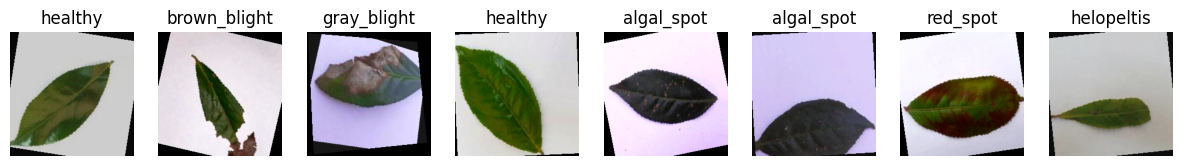


📊 Showing validation batch (no augmentation):


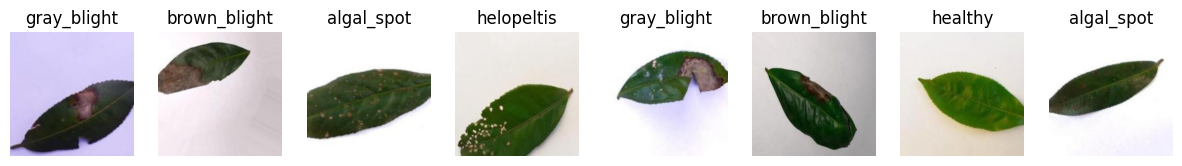

In [6]:
import matplotlib.pyplot as plt

# Undo normalization for visualization
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img_tensor * std + mean

def show_batch(dl, class_to_idx, n=8):
    inv_map = {v:k for k,v in class_to_idx.items()}
    imgs, labels = next(iter(dl))
    imgs, labels = imgs[:n], labels[:n]

    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        img = denormalize(imgs[i]).permute(1,2,0).clamp(0,1)
        axes[i].imshow(img)
        axes[i].set_title(inv_map[labels[i].item()])
        axes[i].axis("off")
    plt.show()

print("\n📊 Showing augmented training batch:")
show_batch(train_loader, class_to_idx)

print("\n📊 Showing validation batch (no augmentation):")
show_batch(val_loader, class_to_idx)